#**SAINLP - Sentiment AI Nlp**

Framework for Sentiment Analysis and more

# **All Imports**

In [ ]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
import sys
import platform
from gensim.models.word2vec import Word2Vec
from gensim.models.phrases import Phrases, Phraser 
import gensim.downloader as gensim_api
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, Input, LSTM, Dense, TimeDistributed, Lambda, Concatenate 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Model, Sequential 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend

from google.colab import drive

# **All Initializations**

In [ ]:
OS = platform.system()   # Operating System
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# **All Globals**

In [ ]:
pretrained_embeddings = False
benchmark = False
language = "italian" # english
ht_to_exclude = ['#ANSA']
default_callbacks = []
save_best_model = True
early_stopping = False
text_length = 34
embeddings_size = 300
#model_type = "recconvnet"
#model_type = "lstm" 
model_type = "bilstm"

#**Hyper Parameters**

#**All Classes**

In [ ]:
class RecConvNet:
    @staticmethod
    def build(input_length, vector_dim, n_classes):
        hidden_dim_RNN = 200
        hidden_dim_Dense = 100        
        
        embedding = Input(shape=(input_length, vector_dim))
        
        left_context = LSTM(hidden_dim_RNN, return_sequences = True)(embedding)												              # Equation 1
        # left_contex: batch_size x tweet_length x hidden_state_dim
        right_context = LSTM(hidden_dim_RNN, return_sequences = True, go_backwards = True)(embedding)						    # Equation 2
        # right_cntext: come left_contex
        together = Concatenate(axis = 2)([left_context, embedding, right_context])											            # Equation 3
        semantic = TimeDistributed(Dense(hidden_dim_Dense, activation = "tanh"))(together)									        # Equation 4	
        pool_rnn = Lambda(lambda x: backend.max(x, axis = 1), output_shape = (hidden_dim_Dense, ))(semantic) 				# Equation 5
        pool_rnn_args = Lambda(lambda x: backend.argmax(x, axis=1), output_shape = (hidden_dim_Dense, ))(semantic)
		
        output = Dense(n_classes, input_dim = hidden_dim_Dense, activation = "softmax")(pool_rnn) 			       					    # Equations 6, 7

        deepnetwork = Model(inputs=embedding, outputs=output)
        deepnetwork_keywords = Model(inputs=embedding, outputs=pool_rnn_args)

        return [deepnetwork, deepnetwork_keywords]


class BiLSTM:
    @staticmethod
    def build(input_length, vector_dim, n_classesm, embeddings_matrix):
        embedding = Input(shape=(text_length,))
        x = Embedding(input_dim=embeddings_matrix.shape[0], output_dim=embeddings_matrix.shape[1], weights=[embeddings_matrix], input_length=text_length, trainable=False)(input)
        x = Bidirectional(LSTM(units=15, dropout=0.2, return_sequences=True))(x)
        x = Bidirectional(LSTM(units=15, dropout=0.2))(x)
        x = Dense(64, activation='relu')(x)
        predictions = Dense(n_classes, activation='softmax')(x)

        model = Model(input, predictions)
        output = Dense(n_classes, activation = 'softmax')(x)

        deepnetwork = Model(inputs=embedding, outputs=output)

        return deepnetwork

# **All General Functions Definitions**

In [ ]:
def explore_data(data): 
  print("\nHead of Data: \n", data.head())
  print("\nTail of Data: \n", data.tail())
  print("\nShape of Data: ", data.shape)
  print("\nInformation about Data: \n")
  try: 
    data.info()
  except: 
    pass
  print("\nTypes of Data attributes: \n")
  try: 
    data.dtypes
  except: 
    pass
  print("\nSummary of all numerical fields in the dataset: \n")
  try: 
    data.describe(include = [np.number])
  except: 
    pass
  print("\nSummary of all categorical fields in the dataset: \n")
  try: 
    data.describe(include = ['O'])
  except: 
    pass
  print("\nLoop Through Each Column and Check for nulls: \n")
  try: 
    for i in range(len(data.columns)):
        print(data.columns[i] + ": " + str(data[data.columns[i]].isna().sum()))
  except: 
    pass

def data_download(file_to_download, gdrive_code, OS, uncompress = True):
  if not os.path.exists(file_to_download):
    os.system('gdown --id "'+gdrive_code+'" --output '+file_to_download)
    if OS == "Linux" and uncompress:
        os.system('unzip -o -n "./'+file_to_download+'" -d "./"')
    return True
  else: 
    return None

# Plot the loss function chart
def plot_loss(history = None):
    plt.figure()												# generate a new window
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend(loc='upper right')
    plt.show(block=False)
    plt.pause(1)

# Plot the accuracy function chart
def plot_acc(history = None):
    plt.figure()												# generate a new window
    plt.plot(history.history['accuracy'], label='train_acc')
    plt.plot(history.history['val_accuracy'], label='val_acc')
    plt.legend(loc='upper left')
    plt.show(block=False)
    plt.pause(1)

In [ ]:
drive.mount('/content/drive')
sys.path.append('/content/drive/My Drive')
model_path = "/content/drive/MyDrive/DL_Models/"


Mounted at /content/drive


# **Data Download**

In [ ]:
if benchmark == True: 
  out = data_download("./News_Category_Dataset_v2.zip", "1O0JTnVgHcYppkR5hmj8sxkpgP4dI164C", OS)
  category_dicts = []
  with open('News_Category_Dataset_v2.json', mode='r', errors='ignore') as json_file:
      for dic in json_file:
          category_dicts.append(json.loads(dic))
else: 
  out = data_download("./tweetHashtah3Giu.zip", "1J2FodTnUeDURmg1I-4AQcbHE0XISILKf", OS)

In [ ]:
out

True

# **Data Preprocessing**

In [ ]:
if benchmark == True:
  data = pd.DataFrame(category_dicts)
  data = data[data["category"].isin(['ENTERTAINMENT','POLITICS','TECH'])][["category","headline"]]
  data = data.rename(columns={"category":"labels", "headline":"text"})
  data = data[['text', 'labels']]     # move cols
  explore_data(data)
else:
  data = pd.read_csv("./tweetHashtah3Giu.csv")
  explore_data(data)



Head of Data: 
                                                 TEXT       hashtag
0   mille scienziati russi a rischio espulsione e...         #Cern
1  una motovedetta libica avrebbe sparato colpi d...         #ANSA
2  la colpa ricadrà sui medici renderanno conto i...  #Risvegliati
3  buongiorno ecco àdioggi salari in cambio della...      #LaVerit
4  le armi inviate all per difendersi contro i ru...      #Ucraina

Tail of Data: 
                                                     TEXT       hashtag
24051   lavorare per la pace è un dovere continuerò a...      #Salvini
24052  salvini se aspettiamo il pd o qualcuno dei ste...   #UkraineWar
24053  oggi esce con una comunicazione funesta al suo...  #Rubrichette
24054  a venezia landini va fermata la guerra sta peg...       #LiveIn
24055  a venezia landini va fermata la guerra sta peg...       #LiveIn

Shape of Data:  (24056, 2)

Information about Data: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24056 entries, 0 to 24055
Data co

In [ ]:
data

,TEXT,hashtag
0,mille scienziati russi a rischio espulsione e...,#Cern
1,una motovedetta libica avrebbe sparato colpi d...,#ANSA
2,la colpa ricadrà sui medici renderanno conto i...,#Risvegliati
3,buongiorno ecco àdioggi salari in cambio della...,#LaVerit
4,le armi inviate all per difendersi contro i ru...,#Ucraina
...,...,...
24051,lavorare per la pace è un dovere continuerò a...,#Salvini
24052,salvini se aspettiamo il pd o qualcuno dei ste...,#UkraineWar
24053,oggi esce con una comunicazione funesta al suo...,#Rubrichette
24054,a venezia landini va fermata la guerra sta peg...,#LiveIn


#**Data Exploration**

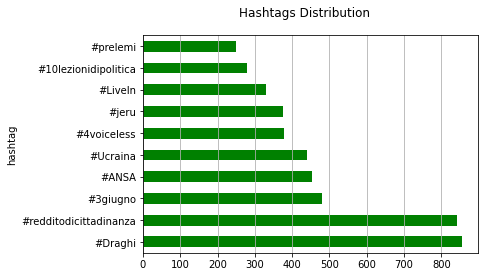

In [ ]:
if benchmark == True: 
  fig, ax = plt.subplots()
  fig.suptitle("Dataset Distribution", fontsize=12)
  data["labels"].reset_index().groupby("labels").count().sort_values(by="index").plot(kind="barh", legend=False, ax=ax, color = "green").grid(axis='x')
  plt.show()
else:
  fig, ax = plt.subplots()
  fig.suptitle("Hashtags Distribution", fontsize=12)
  data["hashtag"].reset_index().groupby("hashtag").count().sort_values(by="index", ascending = False)[0:10].plot(kind="barh", legend=False, ax=ax, color = "green").grid(axis='x')
  ht = data["hashtag"].reset_index().groupby("hashtag").count().sort_values(by="index", ascending = False)[0:10]
  ht_list = list(ht.index)
  ht_list = C = [x for x in ht_list if x not in ht_to_exclude]    # exclude some hashtags
  plt.show()
  filter = "$|".join(ht_list)
  data = data[data.hashtag.str.contains(filter)]
  data.hashtag.value_counts()
  data = data.rename(columns={"hashtag":"labels", "TEXT":"text"})



In [ ]:
filter

'#Draghi$|#redditodicittadinanza$|#3giugno$|#Ucraina$|#4voiceless$|#jeru$|#LiveIn$|#10lezionidipolitica$|#prelemi'

In [ ]:
ht_list

['#Draghi',
 '#redditodicittadinanza',
 '#3giugno',
 '#Ucraina',
 '#4voiceless',
 '#jeru',
 '#LiveIn',
 '#10lezionidipolitica',
 '#prelemi']

In [ ]:
data.reset_index()

,index,text,labels
0,4,le armi inviate all per difendersi contro i ru...,#Ucraina
1,17,ieri c erano a roma i pescatori questo è lo sc...,#Draghi
2,27,a venezia mariastella gelmini prima il covid e...,#LiveIn
3,29,urgentissimo laura,#4voiceless
4,31,milioni di persone evadono le tasse è un viru...,#3giugno
...,...,...,...
4228,24024,il centesimo giorno di guerra significa poco ...,#3giugno
4229,24043,ieri c erano a roma i pescatori questo è lo sc...,#Draghi
4230,24050,a venezia landini va fermata la guerra sta peg...,#LiveIn
4231,24054,a venezia landini va fermata la guerra sta peg...,#LiveIn


# **Data Cleaning Function Definition**

In [ ]:
def clean_text(text, stemming=False, remove_stopwords = True, lemmatization=True, language = language, print_stopwords = False):
  text = re.sub(r'[^\w\s]', '', str(text).lower().strip()) # (1)  
  lst_text = text.split()                                  # (2)
  if remove_stopwords: 
    lst_stopwords = nltk.corpus.stopwords.words(language)
    
    if lst_stopwords is not None:                          # (3)
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
    if print_stopwords: 
      print(lst_text)

  if stemming:                                             # (4)
      ps = nltk.stem.porter.PorterStemmer()
      lst_text = [ps.stem(word) for word in lst_text]
              
  if lemmatization:                                        # (5) 
      lem = nltk.stem.wordnet.WordNetLemmatizer()
      lst_text = [lem.lemmatize(word) for word in lst_text]
          
  text = " ".join(lst_text)                                # (6)
  
  return text

# **Data Cleaning**

In [ ]:
data["text_clean"] = data["text"].apply(lambda x: clean_text(x, remove_stopwords = True, stemming=False, lemmatization=False)) 
explore_data(data)


Head of Data: 
                                                  text       labels  \
4   le armi inviate all per difendersi contro i ru...     #Ucraina   
17  ieri c erano a roma i pescatori questo è lo sc...      #Draghi   
27  a venezia mariastella gelmini prima il covid e...      #LiveIn   
29                                urgentissimo laura   #4voiceless   
31   milioni di persone evadono le tasse è un viru...     #3giugno   

                                           text_clean  
4   armi inviate difendersi russi finiranno econom...  
17  ieri roma pescatori scenario vedremo sempre sp...  
27  venezia mariastella gelmini prima covid poi at...  
29                                 urgentissimo laura  
31  milioni persone evadono tasse virus esiste vac...  

Tail of Data: 
                                                     text    labels  \
24024   il centesimo giorno di guerra significa poco ...  #3giugno   
24043  ieri c erano a roma i pescatori questo è lo sc...   #Draghi   

# **Data Preparation**

In [ ]:
train_set, test_set = train_test_split(data, test_size=0.2)
train_y = train_set["labels"].values
test_y = test_set["labels"].values

In [ ]:
print(len(train_set))
print(len(test_set))
print(len(train_y))
print(len(test_y))

3386
847
3386
847


#**Embeddings Preparation Functions Definition**

In [ ]:
def embeddings_init(data_set, pretrained_embeddings):
  if pretrained_embeddings is True: 
    nlp = gensim_api.load("word2vec-google-news-300")
  else: 
    corpus = data_set["text_clean"]

    # 1 - create list of lists of unigrams
    lst_corpus = []
    i = 0
    for string in corpus:
      lst_words = string.split()
      #print(lst_words)
      lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
      #print(lst_grams)
      lst_corpus.append(lst_grams)
      '''
      i+=1
      if i > 4: 
        break
      '''
      
    # 2 - create a list of bigrams and trigrams
    bigrams_detector = Phrases(lst_corpus, delimiter=" ".encode(), min_count=5, threshold=10)                     # Train a bigram model.
    bigrams_detector = Phraser(bigrams_detector)                                                                  # Export the trained model = use less RAM, faster processing
    trigrams_detector = Phrases(bigrams_detector[lst_corpus], delimiter=" ".encode(), min_count=5, threshold=10)  # Train a trigram model.
    trigrams_detector = Phraser(trigrams_detector)

    return [lst_corpus, bigrams_detector, trigrams_detector]

#**Training Set Embedding Layer with Gensim**

In [ ]:
train_lst_corpus, train_bigrams_detector, train_trigrams_detector = embeddings_init(train_set, pretrained_embeddings)

In [ ]:
print(type(train_lst_corpus))
print(type(train_bigrams_detector))
print(type(train_trigrams_detector))
print(len(train_lst_corpus))
print(train_lst_corpus)

<class 'list'>
<class 'gensim.models.phrases.Phraser'>
<class 'gensim.models.phrases.Phraser'>
3386
[['straurgentissimo'], ['giorni', 'conflitto', 'presidente', 'fa', 'punto', 'gravi', 'conseguenze', 'umanitarie', 'corso', 'pagare', 'persone', 'fragili', 'necessaria', 'rilettura', 'politiche', 'globali', 'leggi', 'blog'], ['rt', 'mariells', 'chanel', 'mercato', 'pesce'], ['sere', 'notizie', 'b', 'sorta', 'domanda', 'dopo', 'luglio', 'abituando', 'troppo', 'bene', 'dimentichiamo', 'due', 'mesi', 'silenzio', 'stampa', 'post', 'gf'], ['governo', 'senza', 'pensarci', 'due', 'volte', 'imposto', 'sanzioni', 'chiudere', 'raffineria', 'lukoil', 'siracusa', 'polo', 'mila', 'dipendenti', 'indotto', 'raffina', 'capacità', 'italiana', 'chiaro', 'vogliono', 'morti', 'sì'], ['centesimo', 'giorno', 'guerra', 'significa', 'poco', 'vittime', 'civili', 'morti', 'feriti', 'dati', 'mezzanotte', 'maggio', 'fonte', 'onu', 'pagato', 'prezzo', 'alto', 'dimenticate'], ['differenza', 'succede', 'attualmente', '

# **Word Embeddings Training by Gensim Word2Vec**

In [ ]:
embedding_model = Word2Vec(train_lst_corpus, size=embeddings_size, window=8, min_count=1, sg=1, iter=30)
if benchmark is True: 
  embedding_model.save(model_path+"news_category_word2vec_embeddings.model")
else: 
  embedding_model.save(model_path+"hashtags_word2vec_embeddings.model")

#**Language Model Sanity Check**

In [ ]:
word = "guerra"
embedding_model[word].shape
print("Embeddings Coefficients for the word: ", word)
print("\n")
print(embedding_model[word])

Embeddings Coefficients for the word:  guerra


[ 0.04808359  0.47234637 -0.01023203  0.29966927  0.09558962 -0.3127226
  0.3812796  -0.16352955  0.09656274 -0.5465361  -0.6143314  -0.4614754
 -0.38869026 -0.14846826 -0.4890364  -0.52895933 -0.02083633  0.17021139
 -0.14845687 -0.26026538 -0.5253809  -0.30706793  0.43322396  0.16773841
  0.34049353 -0.00155195 -0.10075837 -0.13966018 -0.27716902  0.09479411
 -0.4851637   0.48783058 -0.3937008   0.3904015  -0.31606033  0.5060417
 -0.3598291  -0.19561511  0.14272237  0.05210087  0.13506244  0.17180078
  0.30377755  0.19818705  0.00515022  0.10303073  0.236361   -0.57388216
  0.3195972   0.08279996  0.23492418 -0.24408175 -0.533018    0.24323162
  0.15912695 -0.6358669  -0.28172812 -0.02992697  0.16920418  0.16048056
  0.35866955 -0.17689557 -0.13862507  0.00720864 -0.07255618  0.09874856
 -0.4053581  -0.01475401 -0.2894245  -0.5143663  -0.30470705  0.01446402
  0.35582775 -0.78875893 -0.01913283 -0.11320829  0.12961997  0.53495413
 -0.10

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


#**Embedding Space Visualization Function**

In [ ]:
def embedding_space_visualization(root_word, model, plot_3d = True, plot_2d = False):
  tot_words = [word] + [tupla[0] for tupla in model.most_similar(word, topn=40)]   
  X = model[tot_words]
  if plot_2d: 
    fig = plt.figure(figsize=(14, 10), dpi=80)
    pca = TSNE(perplexity=40, n_components=2, init='pca')                           

    X = pca.fit_transform(X)
    pca_data = pd.DataFrame(X, index=tot_words, columns=["x","y"])
    pca_data["input"] = 0
    pca_data["input"].iloc[0:1] = 1

    ax = fig.add_subplot(111)
    ax.scatter(pca_data[pca_data["input"]==0]['x'], pca_data[pca_data["input"]==0]['y'], c="black")
    ax.scatter(pca_data[pca_data["input"]==1]['x'], pca_data[pca_data["input"]==1]['y'], c="red")
    ax.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
    for label, row in pca_data[["x","y"]].iterrows():
        x, y = row
        ax.text(x, y, s=label)
  elif plot_3d: 
    fig = plt.figure(figsize=(20, 17), dpi=80)
    pca = TSNE(perplexity=40, n_components=3, init='pca')                           

    X = pca.fit_transform(X)
    pca_data = pd.DataFrame(X, index=tot_words, columns=["x","y","z"])
    pca_data["input"] = 0
    pca_data["input"].iloc[0:1] = 1

    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_data[pca_data["input"]==0]['x'], pca_data[pca_data["input"]==0]['y'], pca_data[pca_data["input"]==0]['z'], c="black")
    ax.scatter(pca_data[pca_data["input"]==1]['x'], pca_data[pca_data["input"]==1]['y'], pca_data[pca_data["input"]==1]['z'], c="red")
    ax.set(xlabel=None, ylabel=None, zlabel=None, xticklabels=[], yticklabels=[], zticklabels=[])
    for label, row in pca_data[["x","y","z"]].iterrows():
        x, y, z = row
        ax.text(x, y, z, s=label)

# **2D Plot of the Trained Embedding Space**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be 

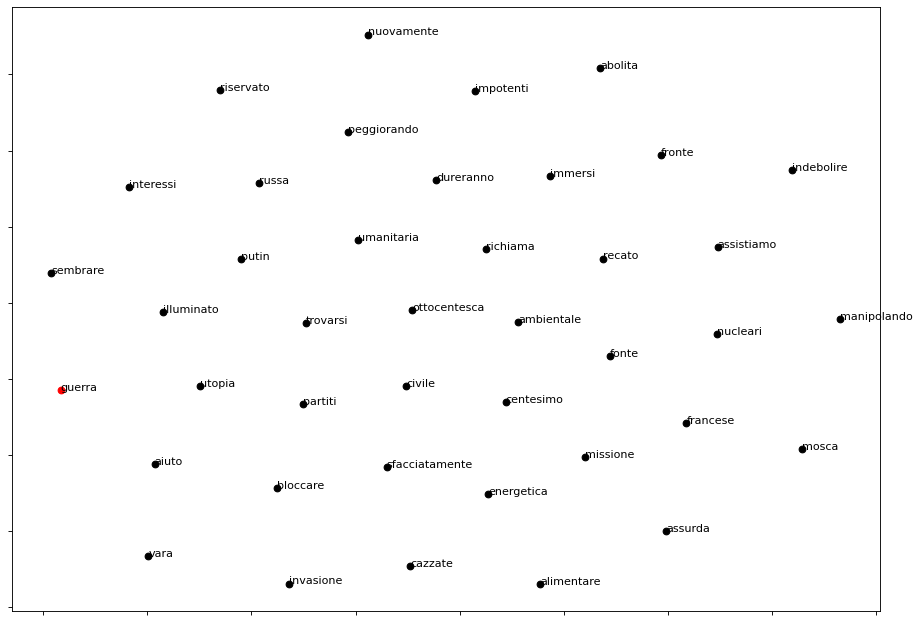

In [ ]:
embedding_space_visualization("guerra", embedding_model, plot_3d = False, plot_2d = True)

# **3D Plot of the Trained Embedding Space**

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be 

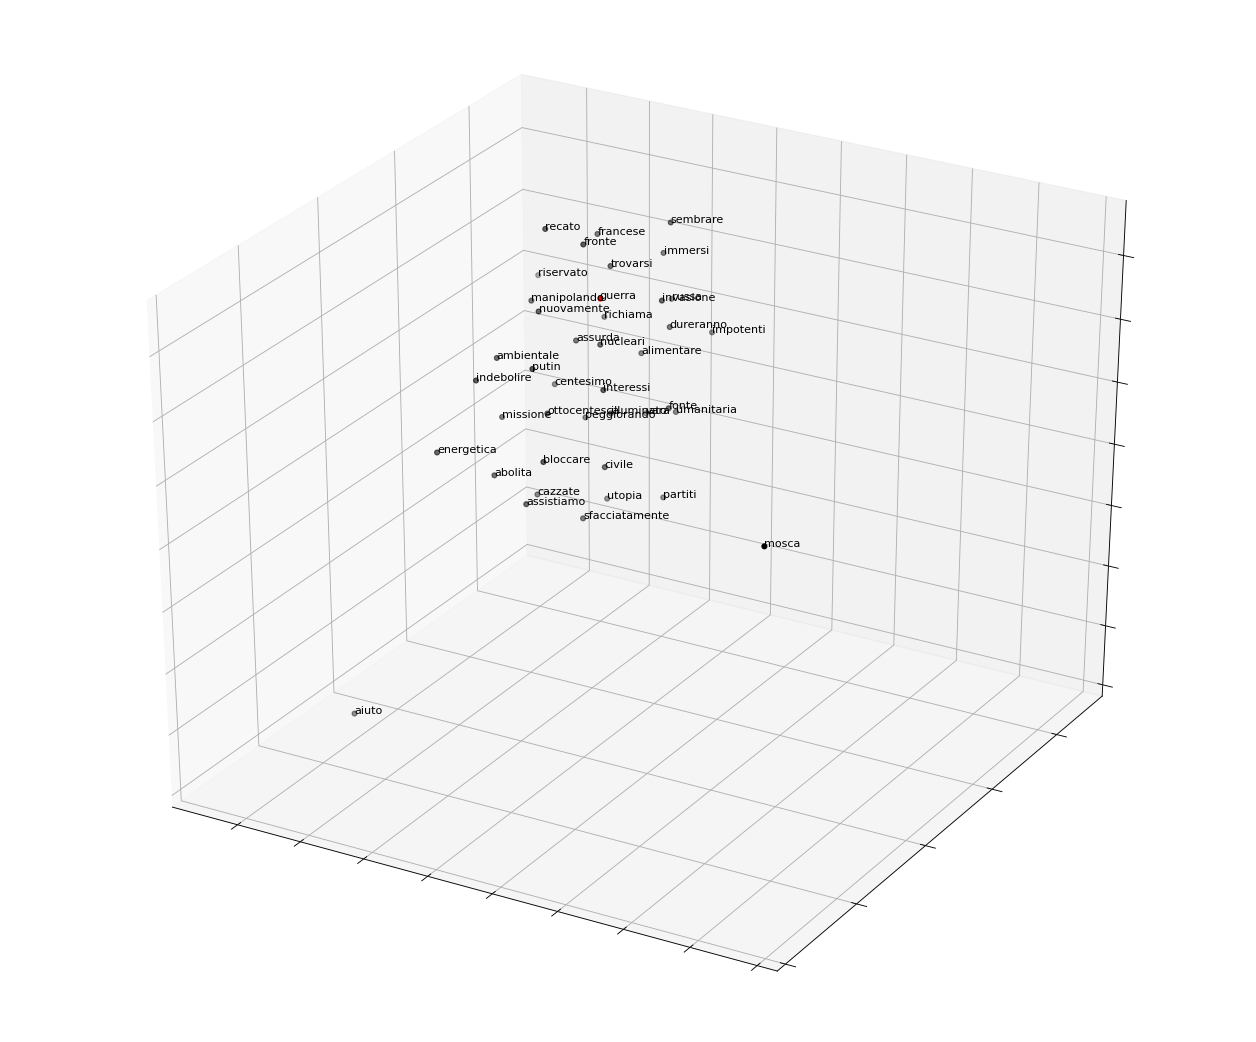

In [ ]:
embedding_space_visualization("guerra", embedding_model, plot_3d = True, plot_2d = False)

#**Feature Engineering Functions Definition**

In [ ]:
def feature_engineering(lst_corpus):
  tokenizer = Tokenizer(lower=True, split=' ', oov_token="NaN", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')  # tokenize text
  tokenizer.fit_on_texts(lst_corpus)
  index_of_words = tokenizer.word_index
  lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)    ## create sequence
  processed_data_set = pad_sequences(lst_text2seq, maxlen=text_length, padding="post", truncating="post") # pad sequences

  return processed_data_set

 # **Feature Engineering**

In [ ]:
train_x = feature_engineering(train_lst_corpus)

In [ ]:
print("Feature Engineering of the Training Set (tokenization, padding, etc..): \n\n", train_x)

Feature Engineering of the Training Set (tokenization, padding, etc..): 

 [[104   0   0 ...   0   0   0]
 [252 412 425 ...   0   0   0]
 [ 80 595 490 ...   0   0   0]
 ...
 [ 80 401 358 ...   0   0   0]
 [ 82  91  69 ...   0   0   0]
 [ 79 162 188 ...   0   0   0]]


#**Training Set Embedding Layer with Gensim**

In [ ]:
test_lst_corpus, test_bigrams_detector, test_trigrams_detector = embeddings_init(test_set, pretrained_embeddings)

NameError: ignored

In [ ]:
'''
corpus = test_set["text_clean"]

lst_corpus = []
for string in corpus:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, 
                 len(lst_words), 1)]
    lst_corpus.append(lst_grams)
    
lst_corpus = list(bigrams_detector[lst_corpus])
lst_corpus = list(trigrams_detector[lst_corpus])
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)

test_x = pad_sequences(lst_text2seq, maxlen=text_length, padding="post", truncating="post")
'''

In [ ]:
print(train_x)
print(len(train_x))
print(test_x)
print(len(test_x))

# **Embeddings Matrix Building**

In [ ]:
embeddings_matrix = np.zeros((len(index_of_words)+1, 300))
for word, idx in index_of_words.items():
    try:
        embeddings_matrix[idx] =  embedding_model[word]
    except:
        pass
print(embeddings_matrix.shape)

# **Labels Encoding**

In [ ]:
print("Original Labels: ")
print(train_y)
print(test_y)
lb_train = LabelEncoder()
lb_train.fit(train_y)
train_y = lb_train.transform(train_y)

lb_test = LabelEncoder()
lb_test.fit(test_y)
test_y = lb_test.transform(test_y)

# save label file so we can use in another script
np.save('./train_labels.npy', lb_train.classes_)
np.save('./test_labels.npy', lb_test.classes_)
print("Encoded Labels: ")
print(train_y)
print(test_y)
n_classes = len(np.unique(train_y))

# **One-Hot Encoding of Outputs**

In [ ]:
n_classes

In [ ]:
print("Original Labels: ")
print(train_y)
print(test_y)
train_y = to_categorical(train_y, num_classes = n_classes)
test_y = to_categorical(test_y, num_classes = n_classes)
print("One-Hot Encoded Labels: ")
print(train_y)
print(test_y)
print(len(train_y))
print(len(test_y))


# **Deep Learning Model Definition**

In [ ]:
if model_type is "bilstm": 
  input = Input(shape=(text_length,))
  x = Embedding(input_dim=embeddings_matrix.shape[0], output_dim=embeddings_matrix.shape[1], weights=[embeddings_matrix], input_length=text_length, trainable=False)(input)
  deepnetwork = BiLSTM.build(input_length=text_length, vector_dim = embeddings_matrix.shape[1], n_classes = n_classes)
  deepnetwork.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])		  
  model = deepnetwork
elif model_type is "recconvnet": 
  embedding = Embedding(input_dim = embeddings_matrix.shape[0], output_dim = embeddings_matrix.shape[1], weights=[embeddings_matrix], input_length=text_length, trainable=False)
  [deepnetwork, deepnetwork_keywords] = RecConvNet.build(input_length=text_length, vector_dim = embeddings_matrix.shape[1], n_classes = n_classes)
  deepnetwork_with_embeddings = Sequential()
  deepnetwork_with_embeddings.add(embedding)
  deepnetwork_with_embeddings.add(deepnetwork)
  deepnetwork_with_embeddings.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])	
  model = deepnetwork_with_embeddings
  '''
  deepnetwork_with_embeddings_keywords = Sequential()
  deepnetwork_with_embeddings_keywords.add(embedding)
  deepnetwork_with_embeddings_keywords.add(deepnetwork_keywords)
  deepnetwork_with_embeddings_keywords.summary()
  '''
elif model_type is "lstm":
  embedding = Embedding(input_dim = embeddings_matrix.shape[0], output_dim = embeddings_matrix.shape[1], weights=[embeddings_matrix], input_length=text_length, trainable=False)
  deepnetwork = DeepLSTM.build(input_length=text_length, vector_dim = embeddings_matrix.shape[1], n_classes = n_classes)
  deepnetwork_with_embeddings = Sequential()
  deepnetwork_with_embeddings.add(embedding)
  deepnetwork_with_embeddings.add(deepnetwork)
  deepnetwork_with_embeddings.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])	
  deepnetwork.summary()
  model = deepnetwork_with_embeddings

model.summary()


In [ ]:
if save_best_model is True:
  if benchmark is True: 
    checkPoint=ModelCheckpoint(model_path+"best_"+model_type+"_news_classifier.h5", save_weights_only=True, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  else: 
    checkPoint=ModelCheckpoint(model_path+"best_"+model_type+"_hashtags_classifier.h5", save_weights_only=True, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

  default_callbacks = default_callbacks+[checkPoint]

if early_stopping is True: 
  earlyStopping=EarlyStopping(monitor='val_loss', min_delta = 0.001, patience=7, verbose=0, mode='min') 
  default_callbacks = default_callbacks+[earlyStopping]

# **Deep Learning Model Training**

In [ ]:
history = training = model.fit(train_x, train_y, batch_size=64, epochs=100, shuffle=True, verbose=1, callbacks = default_callbacks, validation_split=0.2)

In [ ]:
plot_loss(history)
plot_acc(history)

In [ ]:
score = model.evaluate(test_x, test_y, batch_size=500)
print(score)